# Logistic Regression

#### Jessica Morrise

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
import random
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

Function to read in and clean the data.

In [2]:
def initialize(pclass_change=True):
    '''
    Reads and cleans passenger data from the Titanic dataset
    '''
    titanic_data = pd.read_csv('titanic.csv').drop(['Name','Cabin','Body','Ticket','Boat','home.dest','Embarked'], axis=1)
    titanic_data.dropna(inplace=True)
    def mf_boolean(mf):
        if mf=='male':
            return 0
        else:
            return 1
    titanic_data['Sex'] = titanic_data['Sex'].apply(mf_boolean)
    if pclass_change:
        class_dummies = pd.get_dummies(titanic_data['Pclass'])
        class_dummies.drop(3,axis=1,inplace=True)
        titanic_data.drop('Pclass',axis=1,inplace=True)
        titanic_data = pd.concat([titanic_data,class_dummies],axis=1)

    
    survived = np.array(titanic_data['Survived'])
    titanic_data.drop('Survived',axis=1,inplace=True)
    
    data = np.array(titanic_data)
    labels = np.array(survived)
    return train_test_split(data,labels,train_size=0.6)


In [3]:
def best_tau(predictions, true_labels, n_tau=100, plot=True):
    taus = np.linspace(0,1,n_tau+2)
    #taus = taus[1:-1]
    TPR_array = []
    FPR_array = []
    accuracy = []
    for t in taus:
        predicted_labels = np.zeros_like(predictions)
        predicted_labels[predictions>=t] = 1
        true_idx = np.equal(predicted_labels,true_labels)
        true_preds = predicted_labels[true_idx]
        false_preds = predicted_labels[np.logical_not(true_idx)]
        TP = np.sum(true_preds==1)
        TN = np.sum(true_preds==0)
        FP = np.sum(false_preds==1)
        FN = np.sum(false_preds==0)
        #print TP, TN, FP, FN
        TPR = float(TP)/(TP+FN)
        FPR = float(FP)/(FP+TN)
        TPR_array.append(TPR)
        FPR_array.append(FPR)
        accuracy.append(TPR-FPR)
        #print TPR-FPR
    best = taus[np.argmax(accuracy)]
    if plot:
        plt.plot(FPR_array,TPR_array)
        plt.title('ROC curve')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.show()
    return best

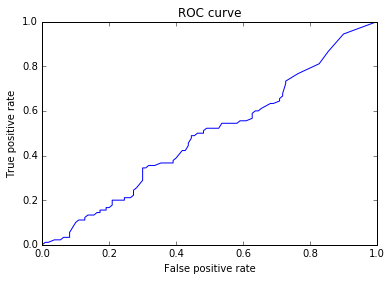

0.44554455445544555

In [4]:
pred_labels = np.random.rand(200)**2
true_labels = np.random.randint(0,2,200)
best_tau(pred_labels,true_labels)

In [5]:
def auc_scores(unchanged_logreg, changed_logreg, unchanged_bayes, changed_bayes):
    u_logreg = LogisticRegression(C=unchanged_logreg)
    c_logreg = LogisticRegression(C=changed_logreg)
    u_nb = MultinomialNB(alpha=unchanged_bayes)
    c_nb = MultinomialNB(alpha=changed_bayes)
    
    u_train_data,u_test_data,u_train_labels,u_test_labels = initialize(pclass_change=False)
    c_train_data,c_test_data,c_train_labels,c_test_labels = initialize(pclass_change=True)
    
    u_logreg.fit(u_train_data,u_train_labels)
    u_logreg_predictions = u_logreg.predict_proba(u_test_data)[:,1]
    u_logreg_auc_score = metrics.roc_auc_score(u_test_labels,u_logreg_predictions)
    
    c_logreg.fit(c_train_data,c_train_labels)
    c_logreg_predictions = c_logreg.predict_proba(c_test_data)[:,1]
    c_logreg_auc_score = metrics.roc_auc_score(c_test_labels,c_logreg_predictions)
    
    u_nb.fit(u_train_data,u_train_labels)
    u_nb_predictions = u_nb.predict_proba(u_test_data)[:,1]
    u_nb_auc_score = metrics.roc_auc_score(u_test_labels,u_nb_predictions)
    
    c_nb.fit(c_train_data,c_train_labels)
    c_nb_predictions = c_nb.predict_proba(c_test_data)[:,1]
    c_nb_auc_score = metrics.roc_auc_score(c_test_labels,c_nb_predictions)
    
    return u_logreg_auc_score,c_logreg_auc_score,u_nb_auc_score, c_nb_auc_score

In [23]:
auc_scores(1.,1.,1.,1.)

(0.83786764705882366,
 0.81338371236424989,
 0.70806451612903221,
 0.6988189444167201)

In [30]:
def find_best_parameters(choices):
    best_vals = np.zeros(4)
    best_auc = np.zeros(4)
    values = np.linspace(0,1,choices+1)
    values = values[1:-1]
    for v in values:
        A = auc_scores(v,v,v,v)
        best_vals[A > best_auc] = v
        best_auc = np.maximum(A,best_auc)
    return best_vals

In [39]:
find_best_parameters(400)

array([ 0.2875,  0.26  ,  0.66  ,  0.1   ])

In [46]:
def results():
    fig = plt.figure(figsize=(7,7))
    
    params = find_best_parameters(200)
    u_logreg = LogisticRegression(C=params[0])
    c_logreg = LogisticRegression(C=params[1])
    u_nb = MultinomialNB(alpha=params[2])
    c_nb = MultinomialNB(alpha=params[3])
    
    u_train_data,u_test_data,u_train_labels,u_test_labels = initialize(pclass_change=False)
    c_train_data,c_test_data,c_train_labels,c_test_labels = initialize(pclass_change=True)
    
    u_logreg.fit(u_train_data,u_train_labels)
    u_logreg_predictions = u_logreg.predict_proba(u_test_data)[:,1]
    fpr,tpr,t = metrics.roc_curve(u_test_labels,u_logreg_predictions)
    plt.plot(fpr,tpr,label='Unchanged Log Reg')
    
    c_logreg.fit(c_train_data,c_train_labels)
    c_logreg_predictions = c_logreg.predict_proba(c_test_data)[:,1]
    fpr, tpr,t = metrics.roc_curve(c_test_labels,c_logreg_predictions)
    plt.plot(fpr,tpr,label='Changed Log Reg')
    
    u_nb.fit(u_train_data,u_train_labels)
    u_nb_predictions = u_nb.predict_proba(u_test_data)[:,1]
    fpr, tpr,t = metrics.roc_curve(u_test_labels,u_nb_predictions)
    plt.plot(fpr,tpr,label='Unchanged Naive Bayes')
    
    c_nb.fit(c_train_data,c_train_labels)
    c_nb_predictions = c_nb.predict_proba(c_test_data)[:,1]
    fpr, tpr,t = metrics.roc_curve(c_test_labels,c_nb_predictions)
    plt.plot(fpr,tpr,label='Changed Naive Bayes')
    
    plt.legend(loc=0)
    plt.show()

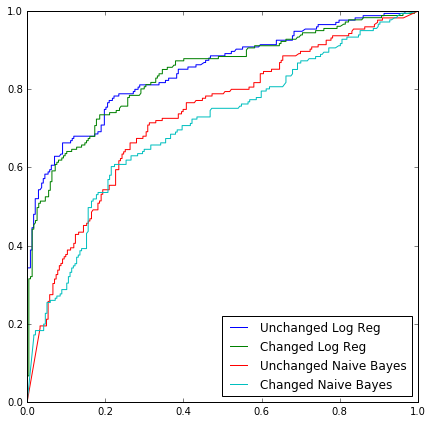

In [51]:
results()